Author: **Hanzhi Helen Tan**


Instruction
https://docs.google.com/document/d/1cPEFea88Y9mvyNGhXVRphjLTzmFlkM7ODpBWhdmUVvI/edit

Task: create transmission spectra, and model to regress on the H20 gas mixing ratio based on the spectra

In [270]:
## feel free to modify this path if you find it doesn't fit, the notebook will use this to store data
import os
current_path = os.getcwd()
print(current_path)

/Users/hanzhitan/Desktop/gsoc


## Import

In [9]:
import numpy as np
import astropy.units as u
from astropy import constants as const
from astropy.constants import G, M_sun
import pytmosph3r as p3
import exo_k as xk
from pathlib import Path
import os
import EPOS
import matplotlib.pyplot as plt
%matplotlib inline

## Fetch Data & Sanity Check
In this section, I found the correct data source and set up the directory used for pytmosph3r simulation. 
Data source: https://forge.oasu.u-bordeaux.fr/amechineau/pytmosph3r-data/-/tree/minimal?ref_type=heads

In [3]:
# # Create directory structure
# !mkdir -p data/corrk data/cia data/aerosol data/xsec data/gcm_output data/chemistry
# # Fetch data
# !wget -P data/corrk/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/corrk_gcm_IR.dat
# !wget -P data/corrk/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/corrk_gcm_VI.dat
# !wget -P data/gcm_output/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/log_IR.out
# !wget -P data/gcm_output/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/log_VI.out
# !wget -P data/xsec/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/narrowbands_IR.in
# !wget -P data/xsec/ https://web.lmd.jussieu.fr/~lmdz/planets/LMDZ.GENERIC/datagcm/corrk_data/CO2_H2Ovar_extreme_16g_with_cont/38x36/narrowbands_VI.in

# # Note: The actual URLs provided above might not be directly downloadable via wget in a real scenario
# # due to potential access restrictions or the need for authentication.
# # The provided commands assume direct access is available.


In [267]:
## following two cells are copied from the Pytmosph3R instruction page with a few modifications

In [155]:
from pathlib import Path

# Path where the data are stored
data_path: Path = Path(current_path) / 'data'

xsec_path = (data_path / "corrk").as_posix()
aerosol_path = (data_path / "aerosol").as_posix()
cia_path = (data_path / "cia").as_posix()
xk.Settings().set_search_path(xsec_path)
xk.Settings().set_cia_search_path(cia_path)
xk.Settings().set_aerosol_search_path(aerosol_path)
#xk.Settings().set_delimiter(".")
xk.Settings().set_mks(True) 
xk.Settings().set_log_interp(False)

In [26]:
Rp = 1.807 * 6.9911e7 * u.Unit('m')
g0 = 6.67384e-11 * 1.183 * 1.898e27 / Rp**2 * u.Unit('m3*s-2')


orbit=p3.CircularOrbit(a=1.*u.au)
planet = p3.Planet(surface_gravity=g0, radius=Rp)
star = p3.Star.fromSolar(temperature=6460.0, radius=1.458) # radius is in sun radii
grid = p3.Grid3D(n_vertical=100, n_latitudes=1, n_longitudes=1)
input_atmosphere = p3.InputAtmosphere(grid=grid,
     temperature = 2000,
     max_pressure = 1e6, min_pressure = 1e-4,
     gas_mix_ratio = {"H2O":5.01187234e-01, #ratio to simulate
                      "H2":"background"
                     },
     transparent_gases = "H2")
observer = p3.Observer(0, 180) # latitude, longitude in degrees
rays = p3.Rays(n_radial=100, n_angular=1)
opacity = p3.Opacity(rayleigh=True, cia=['H2', 'H2O'])


In [27]:
model = p3.Model(n_vertical = 100,
                 planet=planet,
                 star=star,
                 orbit=orbit,
                 observer=observer,
                 input_atmosphere=input_atmosphere,
                 transmission=p3.Transmission(rays=rays),
                 opacity=opacity,)

model.build()

pytmosph3r.Model - INFO - Loading model attributes from config file...
pytmosph3r.Model - INFO - Setting planet.margin = 1
pytmosph3r.Model - INFO - Setting planet.mass = 2.245334e+27
pytmosph3r.Model - INFO - Setting planet.mass_jup = 1.1829223451143542
pytmosph3r.Model - INFO - Setting planet.radius = 126329177.0
pytmosph3r.Model - INFO - Setting planet.radius_jup = 1.7670393470598107
pytmosph3r.Model - INFO - Setting planet.surface_gravity = 9.389650117079357
pytmosph3r.Model - INFO - Setting planet.verbose = 0
pytmosph3r.Model - INFO - Setting star.margin = 1
pytmosph3r.Model - INFO - Setting star.mass = 1.988409870698051e+30
pytmosph3r.Model - INFO - Setting star.mass_sol = 0.9999999999999999
pytmosph3r.Model - INFO - Setting star.radius = 1014330600.0
pytmosph3r.Model - INFO - Setting star.radius_sol = 1.458
pytmosph3r.Model - INFO - Setting star.temperature = 6460.0
pytmosph3r.Model - INFO - Setting star.verbose = 0
pytmosph3r.Model - INFO - Setting input_atmosphere.aerosols (le

pytmosph3r.Model - INFO - Running model...
pytmosph3r.Opacity - INFO - Exo_k: Loading gas database for ['H2O']... (H2 considered transparent)


be careful: ()
            String filters not specific enough, several corresponding files have been found.
            We will use the first one:
            /Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.TauREx.h5
            Other files are:
            ['/Users/hanzhitan/Desktop/gsoc/data/corrk/H2O_R300_0.3-50mu.ktable.SI.h5']


pytmosph3r.Opacity - INFO - Exo_k: Loading CIA database for ['H2', 'H2O']...
pytmosph3r.Opacity - INFO - Exo_k: Loading aerosols database for []...
pytmosph3r.Opacity - INFO - Exo_k: loading databases - DONE
pytmosph3r.Model - INFO - Switching to transmission


  0%|          | 0/1 [00:00<?, ?it/s]

pytmosph3r.Transmission - WARNING - `identical` option useless. Maybe remove it next time? Your atmosphere is completely heterogeneous so we can't find identical cells.
pytmosph3r.Model - INFO - Saving transmission outputs into None ...
pytmosph3r.Model - INFO - Save - DONE
pytmosph3r.Model - INFO - Save - DONE


Saved to `outputs/spectrum_pytmosph3r.pdf`


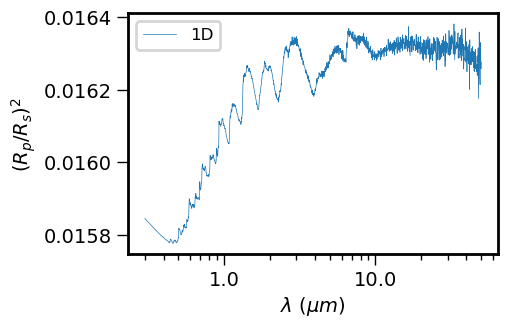

In [30]:
model.run()
plot = p3.Plot(model=model, label="1D", interactive=True, out_folder="outputs")
plot.plot_spectrum()

## Data Simulation

* in terms of the **radius and orbit** distribution of transit planet, I decided to ignore the observational bias and refer to https://iopscience.iop.org/article/10.3847/1538-4357/ab5187 / Exoplanet Population Observation Simulator for the model. I use Kepler DR25 for the real world distribution, and Monte-Carlo method for the simulation.

### Period & Radii Data
days vs size of earth -> meter


 |~| epos 3.0.2 |~|

Initializing 'example_1'

Using random seed 3604974129
Survey: None selected

Loading planets from temp/q1_q17_dr25_koi.npz
  6853/7995 dwarfs
  3525 candidates, 3328 false positives
  3040+1 with score > 0.90

Observations:
  159238 stars
  3041 planets

  1840 singles, 487 multis
  - single: 1840
  - double: 324
  - triple: 113
  - quad: 38
  - quint: 10
  - sext: 2


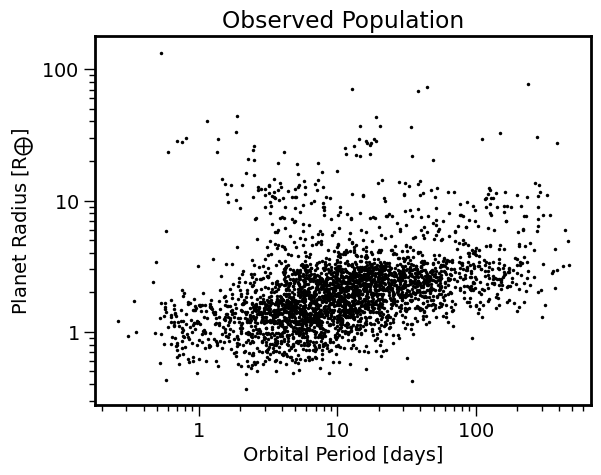

In [3]:
##distribution of the observed data
%matplotlib inline
epos= EPOS.epos(name='example_1')
obs, survey= EPOS.kepler.dr25(Huber=True, Vetting=True, score=0.9)
epos.set_parametric(EPOS.fitfunctions.brokenpowerlaw2D)
epos.set_survey(**survey)
epos.set_observation(**obs)
EPOS.plot.survey.observed(epos, NB=True, PlotBox=False)

In [4]:
epos.fitpars.add('pps',             2.0,    min=0,                  isnorm=True)

epos.fitpars.add('P break', 10.,    min=2,  max=50, is2D=True)
epos.fitpars.add('a_P',             1.5,    min=0,                  is2D=True)
epos.fitpars.add('b_P',             0.0,    dx=0.1,                 is2D=True)
epos.fitpars.add('R break', 3.0,    min=1.0,max=5,  is2D=True)
epos.fitpars.add('a_R',             0.0,    dx=0.1,                 is2D=True)
epos.fitpars.add('b_R',             -4.,    fixed=True,     is2D=True)
epos.set_ranges(xtrim=[0,730],ytrim=[0.3,20.],xzoom=[2,400],yzoom=[1,6], Occ=True)
EPOS.run.once(epos)
EPOS.run.mcmc(epos, nMC=5000, nwalkers=100, nburn=200, threads=20, Saved=True)
epos.set_bins(xbins=[[2,400],[0.9*365,2.2*365]], ybins=[[1,6],[0.7,1.5]]) # eta_zoom, eta_earth
EPOS.occurrence.all(epos)


Preparing EPOS run...
  6 fit parameters

Starting the first MC run
Finished one MC in 0.054 sec

Loading saved status from chain/example_1/100x5000x6.npz

NOTE: Random seed changed: 687655369 to 3604974129

MC-ing the 30 samples to plot

Best-fit values
  pps= 4.7 +1.53 -1.22
  P break= 12.4 +4.98 -3.35
  a_P= 1.6 +0.556 -0.258
  b_P= 0.247 +0.121 -0.2
  R break= 3 +0.167 -0.179
  a_R= -0.395 +0.249 -0.216

Starting the best-fit MC run

Goodness-of-fit
  logp= -1.7
  - p(n=2335)=1
  - p(x)=0.42
  - p(y)=0.43

  Akaike/Bayesian Information Criterion
  - k=6, n=2336
  - BIC= 49.9
  - AIC= 15.4, AICc= 0.6
  observation comparison in 0.004 sec

Interpolating planet occurrence

  Observed Planets
  x: [2,400], y: [1,6], n=2336, comp=0.037, occ=1.1
  x: [328,803], y: [0.7,1.5], n=0, comp=nan, occ=0

  x zoom bins
  x: [2,400], y: [0.25,0.32], n=0, comp=nan, occ=0
  x: [2,400], y: [0.32,0.41], n=1, comp=0.0011, occ=0.0055
  x: [2,400], y: [0.41,0.53], n=8, comp=0.002, occ=0.82
  x: [2,400],

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  gamma= 13.6% +2.3% -2.3%
  eta= 129.1% +22.0% -21.7%
  x: [328,803], y: [0.7,1.5], area=0.68, eta_0=0.1
  gamma= 51.6% +21.5% -21.5%
  eta= 35.2% +14.7% -14.6%

  Binned occurrence rate metrics
  x: (n=12, k=6)
    chi^2= 174.4, reduced= 29.1
    bic= 47.0
    aic= 73.9, AICc= 1242.1
  y: (n=7, k=6)
    chi^2= 157.0, reduced= 157.0
    bic= 33.4
    aic= 47.4, AICc= inf


/opt/anaconda3/lib/python3.11/site-packages/EPOS/analytics.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  cfactor= (2.* k_free**2. + 2.*k_free) / (n_data- k_free - 1.)


In [5]:
print(epos.synthetic_survey)
epos.synthetic_survey['P'].shape

{'P': array([  9.40419719,  36.6125478 ,  16.78788205, ...,  32.10170404,
         1.59758002, 158.53334341]), 'Y': array([1.81386022, 1.36020776, 1.17533192, ..., 1.27792703, 0.54257975,
       1.94724578]), 'P zoom': array([  9.40419719,  36.6125478 ,  16.78788205, ...,   7.65703797,
        32.10170404, 158.53334341]), 'Y zoom': array([1.81386022, 1.36020776, 1.17533192, ..., 1.05680671, 1.27792703,
       1.94724578]), 'nobs': 2335}


(3056,)

(3056,) (3056,)


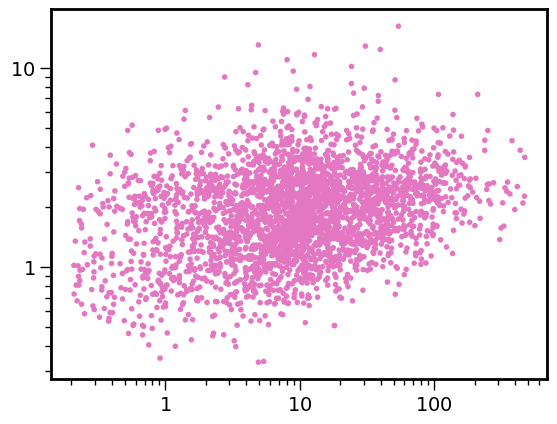

In [6]:
## Distribution of the simulated Data
simulated_periods = epos.synthetic_survey['P']
simulated_radii = epos.synthetic_survey['Y']
plt.xscale('log')
plt.yscale('log')

plt.scatter(simulated_periods, simulated_radii, ls='', marker='.', color='C6')
print(simulated_periods.shape, simulated_radii.shape)

In [13]:
#storage and load

combined_array = np.concatenate((simulated_periods, simulated_radii))
# Specify the file path where the 2D array will be stored
file_path = current_path + "/p_r.npy"
np.save(file_path, combined_array)

combined_array_loaded = np.load(file_path)
print("Combined array loaded from:", file_path)
print("Combined array:", combined_array_loaded)

Combined array loaded from: /Users/hanzhitan/Desktop/gsoc/p_r.npy
Combined array: [ 9.40419719 36.6125478  16.78788205 ...  1.27792703  0.54257975
  1.94724578]


### Final Input Data
I generate the final spectrum for the training purpose using the period and radius data generated in the previous section. Most other parameters are set to be default values for simplicity purposes (eg. the star, other metrics except H2O ratio of the atmosphere.) I use a uniform random generator to create H2O ratio in a reasonable range (1% to 100%) and don't take the atmosphere type distribution into consideration.

In [140]:
def period_to_semimajor_axis(P_days, star_mass_Msun=1):
    """
    Convert orbital period in days to semi-major axis in astronomical units (AU),
    given the star's mass in solar masses.
    
    Parameters:
    - P_days: Orbital period in days.
    - star_mass_Msun: Mass of the star in solar masses.
    
    Returns:
    - a: Semi-major axis in astronomical units (AU).
    """
    P_seconds = P_days * 24 * 3600
    star_mass_kg = star_mass_Msun * M_sun.value
    a_meters = ((G.value * star_mass_kg * P_seconds**2) / (4 * np.pi**2)) ** (1/3)
    
    # Convert semi-major axis to astronomical units
    a_au = a_meters / u.au.to(u.m)
    
    return a_au


In [141]:
def generate_model(P_day, radius, h20_ratio):
    """
    Convert orbital period in days to semi-major axis in astronomical units (AU),
    given the star's mass in solar masses.
    
    Parameters:
    - P_days: Orbital period in days.
    - radius: radius of the planet in meter.
    = h20_ratio: ratio of H20 in the atmosphere
    
    Returns:
    - model.spectrum: object including (Rp/Rs)^2 and wavelength micrometer
    """
    Rp = 1.807 * 6.9911e7 * radius * u.Unit('m')
    g0 = 6.67384e-11 * 1.183 * 1.898e27 / Rp**2 * u.Unit('m3*s-2')
    star = p3.Star.fromSolar(temperature=6460.0, radius=1.458) # radius is in sun radii
    semi_major_axis = period_to_semimajor_axis(P_day)
    
    orbit=p3.CircularOrbit(a=semi_major_axis*u.au)
    planet = p3.Planet(surface_gravity=g0, radius=Rp)
    grid = p3.Grid3D(n_vertical=100, n_latitudes=1, n_longitudes=1)
    input_atmosphere = p3.InputAtmosphere(grid=grid,
    
         temperature = 2000,
         max_pressure = 1e6, min_pressure = 1e-4,
    
         gas_mix_ratio = {"H2O":h20_ratio, #ratio to simulate
                          "H2":"background"
                         },
         transparent_gases = "H2")
    observer = p3.Observer(0, 180) # latitude, longitude in degrees
    rays = p3.Rays(n_radial=100, n_angular=1) # in 1D cases, only 1 angle is required
    opacity = p3.Opacity(rayleigh=True, cia=['H2', 'H2O'])
    
    model = p3.Model(n_vertical = 100,
                     planet=planet,
                     star=star,
                     orbit=orbit,
                     observer=observer,
                     input_atmosphere=input_atmosphere,
                     transmission=p3.Transmission(rays=rays),
                     opacity=opacity,);
    
    model.build();
    model.run();
    return model #.spectrum

In [142]:
# m = generate_model(simulated_periods[0], simulated_radii[0], 1e-2)
# plot = p3.Plot(model=model, label="1D", interactive=True, out_folder="outputs")
# plot.plot_spectrum()
# print(model.spectrum) #(Rp/Rs)^2 vs wavelength micrometer

In [144]:
file_path = current_path + "/p_r.npy"
combined_array = np.load(file_path)


n = combined_array.shape[0] // 2  # assuming combined_array is a 1D array
simulated_periods = combined_array[:n]
simulated_radii = combined_array[n:]

In [257]:
# # Generation of the Input Data
import random
r_ratio, wls, H20_ratio = [], [], [] #shape - [n, 1538], [n, 1538], n
for i in range(len(simulated_periods)//4):
    try:
        ratio = random.uniform(1e-2, 1);
        m = generate_model(simulated_periods[i], simulated_radii[i], ratio)
        r_ratio.append(m.spectrum.value)
        wls.append(m.spectrum.wls)
        H20_ratio.append(ratio)
    except:
        continue

In [161]:
input_features = np.concatenate((np.array(r_ratio), np.array(wls)), axis=1)
print(input_features.shape)
input_features_path = current_path + "/input_features.npy"
np.save(input_features_path, input_features)
h2o_ratios_path = current_path + "/h20_ratios.npy"
np.save(h2o_ratios_path, np.array(H20_ratio))

(764, 3076)


## Model and Training

**Run this part directly if you have downloaded training data from the google drive I refer to, go to the prediction part if you used the pretrained model**

Data: 
* Spectrum - represented as 2D array (n, Radius Ratio/transition depth)
* Value to Predict: a fraction/float (H2O mix ratio)

Model: I use a simple fully-connected network due to the simplicity of the input data and the value to predict, I treat it as a regression problem.

In [ ]:
import numpy as np
import astropy.units as u
from astropy import constants as const
from astropy.constants import G, M_sun
import pytmosph3r as p3
import exo_k as xk
from pathlib import Path
import os
import EPOS
import matplotlib.pyplot as plt
%matplotlib inline

In [162]:
h2o_ratios_path = current_path + "/h20_ratios.npy"
input_features_path = current_path + "/input_features.npy"
input_features = np.load(input_features_path)
h2o_ratios = np.load(h2o_ratios_path)

In [262]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

#normalize data, split into training/validation/testing dataset
radius_scaler = MinMaxScaler()
radius_features_scaled = radius_scaler.fit_transform(radius_features)
input_features_scaled = radius_features_scaled

X_train, X_temp, y_train, y_temp = train_test_split(input_features_scaled, h2o_ratios, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [260]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(1538,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mae'])


In [261]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=250, batch_size=64)


Epoch 1/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3684 - mae: 0.5255 - val_loss: 0.3330 - val_mae: 0.4963
Epoch 2/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3188 - mae: 0.4829 - val_loss: 0.3148 - val_mae: 0.4779
Epoch 3/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3021 - mae: 0.4643 - val_loss: 0.2905 - val_mae: 0.4543
Epoch 4/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2663 - mae: 0.4318 - val_loss: 0.2667 - val_mae: 0.4303
Epoch 5/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2592 - mae: 0.4275 - val_loss: 0.2436 - val_mae: 0.4070
Epoch 6/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2443 - mae: 0.4156 - val_loss: 0.2205 - val_mae: 0.3854
Epoch 7/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2173 - mae: 0.3908 - val_loss: 0.1978 - val_mae: 0.3635
Epoch 8/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1869 - mae: 0.3564 - val_loss: 0.1786 - val_mae: 0.3428
Epoch 9/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1809 - mae: 0.3397 -

In [252]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0527 - mae: 0.1307
Test Loss: 0.06778371334075928, Test MAE: 0.14154194295406342


## Results

There're a few outliers but predictions essentially capture the trend and correctly predict the ratio ( <0.5 or > 0.5) after 250 epochs of training. (The loss significantly decrease around epoch 25).

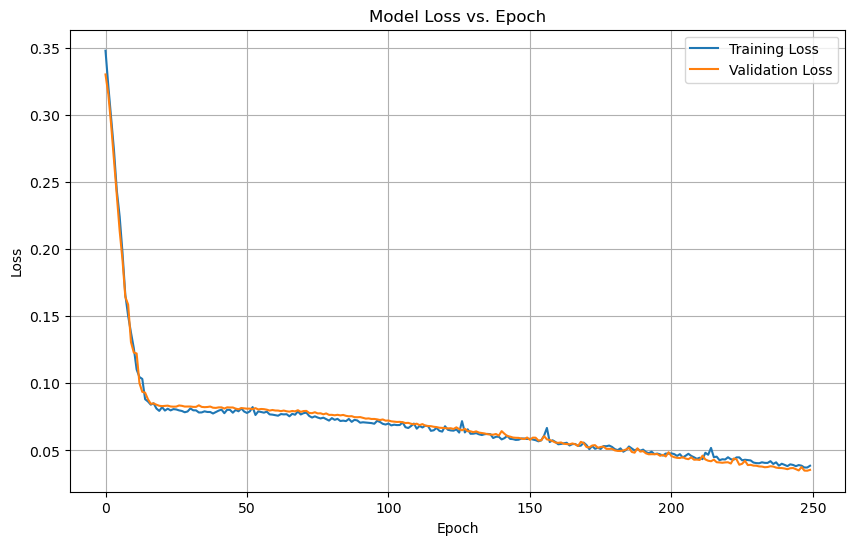

In [253]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


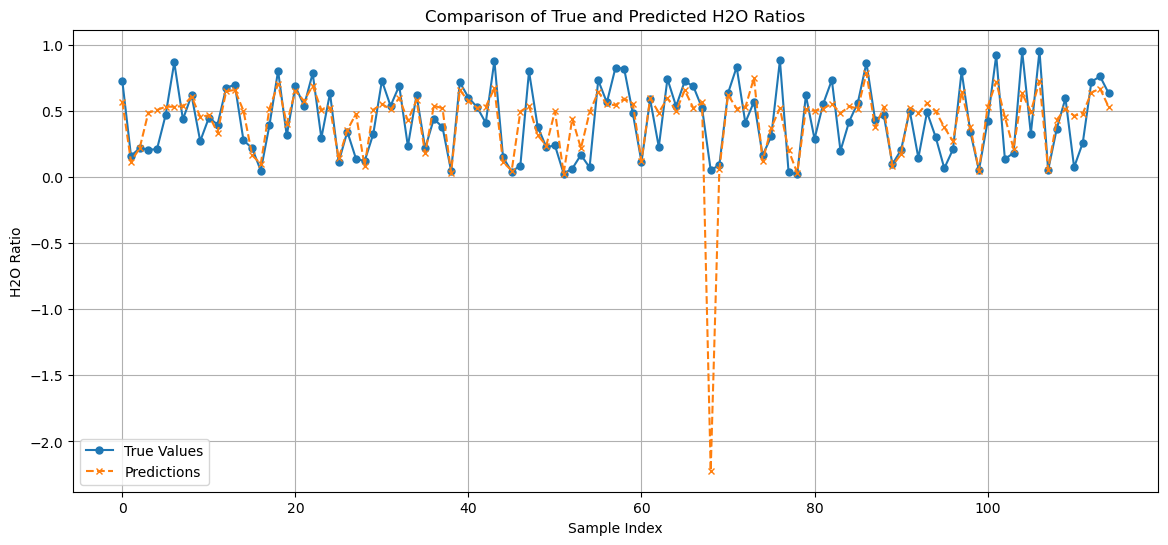

In [254]:
# Generate predictions for the test set
predictions = model.predict(X_test).flatten()

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='True Values', marker='o', linestyle='-', markersize=5)
plt.plot(predictions, label='Predictions', marker='x', linestyle='--', markersize=5)
plt.title('Comparison of True and Predicted H2O Ratios')
plt.xlabel('Sample Index')
plt.ylabel('H2O Ratio')
plt.legend()
plt.grid(True)
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


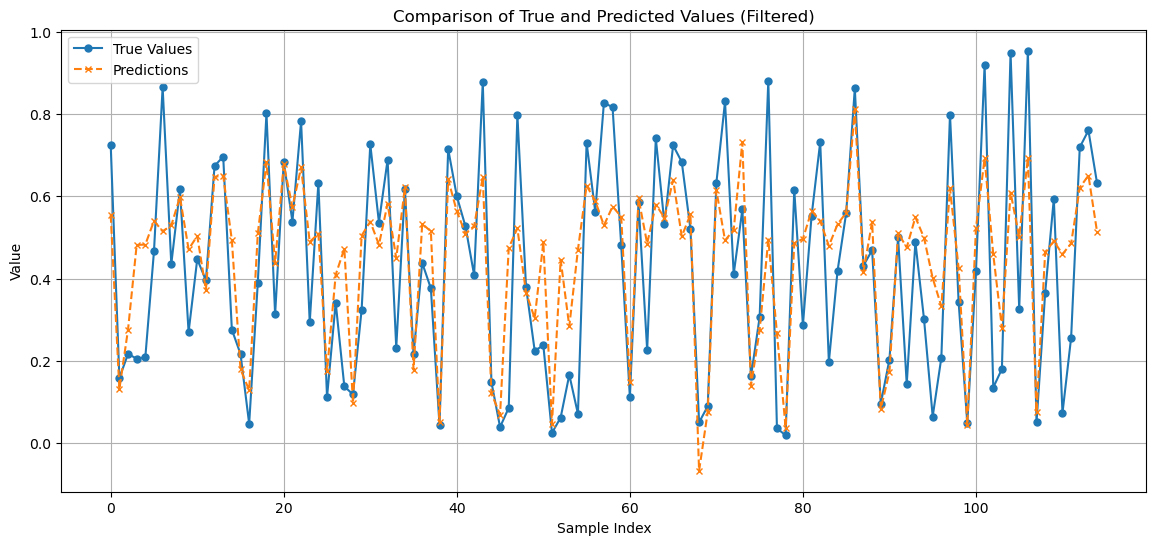

In [266]:
#figure without outlier
predictions = model.predict(X_test).flatten()

differences = np.abs(predictions - y_test)

threshold = 2.0
small_diff_indices = np.where(differences < threshold)[0]

filtered_predictions = predictions[small_diff_indices]
filtered_y_test = y_test[small_diff_indices]

plt.figure(figsize=(14, 6))
plt.plot(filtered_y_test, label='True Values', marker='o', linestyle='-', markersize=5)
plt.plot(filtered_predictions, label='Predictions', marker='x', linestyle='--', markersize=5)
plt.title('Comparison of True and Predicted Values (Filtered)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [256]:
model.save(current_path + '/h20_prediction_model.keras')  # Saves the model to a SavedModel directory